That last notebook got messy so I'm making a new cleaner one that will enable me to sample over both emulators simultaneously. 

In [1]:
import matplotlib
#matplotlib.use('Agg')
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [2]:
import numpy as np
import h5py
from chainconsumer import ChainConsumer
#from corner import corner
from ast import literal_eval
from pearce.emulator import LemonPepperWet
from os import path
from scipy.linalg import inv

 /u/ki/swmclau2/.conda/envs/hodemulator/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning:numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.


In [3]:
fname = '/u/ki/swmclau2/des/PearceMCMC/ShuffledSHAM_wp_ds_rmin_0.5_HOD.hdf5'

In [4]:
f = h5py.File(fname, 'r')

In [5]:
tf = f.attrs['training_file']
fixed_params = literal_eval(f.attrs['fixed_params'])
if 'rmin' in fixed_params:
    del fixed_params['rmin']
emu_hps = literal_eval(f.attrs['emu_hps'])

In [6]:
tf

array(['/u/ki/swmclau2/des/Aemulators/wp_zheng07/PearceWpCosmo.hdf5',
       '/u/ki/swmclau2/des/Aemulators/ds_zheng07/PearceDsCosmo.hdf5'],
      dtype='|S59')

In [7]:
emus = []
for t in tf:
    print t
    emus.append(LemonPepperWet(t, fixed_params = fixed_params, hyperparams = emu_hps) )

/u/ki/swmclau2/des/Aemulators/wp_zheng07/PearceWpCosmo.hdf5
/u/ki/swmclau2/des/Aemulators/ds_zheng07/PearceDsCosmo.hdf5


In [8]:
chain_pnames = f.attrs['param_names']

In [9]:
n_walkers = f.attrs['nwalkers']

In [10]:
n_burn = 1000
chain = f['chain'][n_burn*n_walkers:, :]

In [11]:
rmin = eval(f.attrs['fixed_params'])['rmin'] if 'rmin' in f.attrs['fixed_params'] else 0

In [12]:
n_params = chain.shape[1] if len(chain.shape) > 1 else 1

In [13]:
print chain.shape, chain.shape[0]/n_walkers

(1001000, 12) 4004


In [14]:
c = ChainConsumer()
chain = chain.reshape((-1, n_walkers, chain.shape[1]))
chain = chain.reshape((-1, chain.shape[2]), order = 'F')
c.add_chain(chain, parameters=list(chain_pnames), walkers = n_walkers)


In [15]:
#MAP = chain.mean(axis = 0)
summary = c.analysis.get_summary(chains=0)
MAP = np.array([summary[key][1] for key in chain_pnames])
print MAP

[ 2.21457780e-02  1.20518620e-01 -1.39331978e+00  9.97265411e-01
  7.47500504e+01  3.99701439e+00  8.52783271e-01  1.44956678e+01
  1.30572998e+01  4.98815655e-01  8.05531388e-01  7.98680380e-01]


In [16]:
chain_pnames

array(['ombh2', 'omch2', 'w0', 'ns', 'H0', 'Neff', 'sigma8', 'logM1',
       'logM0', 'sigma_logM', 'alpha', 'conc_gal_bias'], dtype='|S13')

In [17]:
MAP_dict = dict(zip(chain_pnames, MAP))

In [18]:
#fixed_params = eval(f.attrs['chain_fixed_params'])
#fixed_params.update(eval(f.attrs['sim'])['cosmo_params'])

In [19]:
MAP_dict.update(fixed_params)

In [20]:
MAP_dict

{'H0': 74.75005037590648,
 'Neff': 3.9970143894959707,
 'alpha': 0.8055313884220497,
 'conc_gal_bias': 0.7986803795790649,
 'logM0': 13.057299805926396,
 'logM1': 14.49566783172274,
 'ns': 0.9972654106229115,
 'ombh2': 0.022145777970531806,
 'omch2': 0.12051862041674496,
 'sigma8': 0.8527832710707373,
 'sigma_logM': 0.4988156554231233,
 'w0': -1.3933197831762614,
 'z': 0.0}

In [21]:
MAP_pred = np.hstack([emu.emulate_wrt_r(MAP_dict, r_bin_centers=emu.scale_bin_centers).squeeze() for emu in emus])
MAP_pred = MAP_pred.reshape((len(emus), -1))

In [22]:
hod_idxs = np.array(range(7, len(chain_pnames)))
cosmo_idxs = np.array(range(7))

In [23]:
if chain.shape[1] == 7:
    cosmo_chain = chain
else:
    hod_chain = chain[:,7:]#[:, hod_idxs]
    cosmo_chain = chain[:,:7]#[:, cosmo_idxs]

In [24]:
from pearce.mocks import cat_dict
cosmo_params = {}

In [25]:
h = 0.6777
cosmo_pnames = ['ombh2', 'omch2', 'w0', 'ns', 'H0', 'Neff', 'sigma8']
cosmo_true_vals = np.array([0.048206*h**2, 0.307115*h**2-0.048206*h**2,\
                            -1, 0.9667, \
                                h*100, 3.046, 0.8228]) #mdpl2

cat_val_dict = dict(zip(cosmo_pnames, cosmo_true_vals))

In [26]:
cat_val_dict

{'H0': 67.77,
 'Neff': 3.046,
 'ns': 0.9667,
 'ombh2': 0.022139921041739997,
 'omch2': 0.11891102387661,
 'sigma8': 0.8228,
 'w0': -1.0}

In [27]:
true_param_dict = cat_val_dict.copy()
#hod_params = {'alpha': 1.083, 'conc_gal_bias': 1.0, 'logM0': 13.2,'logM1': 14.2, 'sigma_logM': 0.2}#sim_info['hod_params']
hod_params = {'alpha': 1.03887697, 'conc_gal_bias': 1.0, 'logM0': 11.41003864,\
              'logM1': 14.56088772, 'sigma_logM': 0.44415644}#sim_info['hod_params']



#hod_params['mean_occupation_centrals_assembias_param1'] = 0.0
#hod_params['mean_occupation_satellites_assembias_param1'] =0.0
#hod_params['mean_occupation_centrals_assembias_slope1'] = 0.0
#hod_params['mean_occupation_satellites_assembias_slope1'] = 0.0
#hod_params['mean_occupation_centrals_assembias_corr1'] = 0.0
#hod_params['mean_occupation_satellites_assembias_corr1'] =0.0

#for pname in emu.get_param_names():
#    if 'mean_occupation' in pname:
#        hod_params[pname] = 0.0

for hp, hv in hod_params.iteritems():
    if hp == 'logMmin':
        continue
    true_param_dict[hp] = hv

true_param_dict['conc_gal_bias'] = 1.0
true_pred = emu.emulate_wrt_r(true_param_dict)[0]

 /u/ki/swmclau2/.local/lib/python2.7/site-packages/pearce/emulator/emu.py:506: UserWarning:Emulator value for logM0 11.410 is outside the bounds (12.600, 13.600) of the emulator.


In [28]:
true_param_dict

{'H0': 67.77,
 'Neff': 3.046,
 'alpha': 1.03887697,
 'conc_gal_bias': 1.0,
 'logM0': 11.41003864,
 'logM1': 14.56088772,
 'ns': 0.9667,
 'ombh2': 0.022139921041739997,
 'omch2': 0.11891102387661,
 'sigma8': 0.8228,
 'sigma_logM': 0.44415644,
 'w0': -1.0}

In [29]:
true_data = f['data'][()]#.flatten()

In [30]:
true_data = true_data.reshape((len(emus), -1))

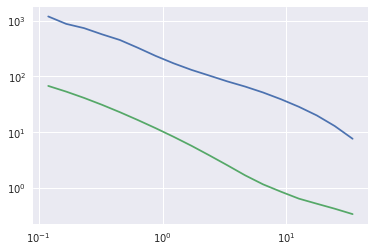

In [31]:
plt.plot(emu.scale_bin_centers, true_data[0])
plt.plot(emu.scale_bin_centers, true_data[1])

plt.loglog();

In [32]:
rbc = emu.scale_bin_centers#[-len(emu.scale_bin_centers):]

In [33]:
cov = f['cov'][()]
yerr = np.sqrt(np.diag(cov)).reshape((len(emus), -1))

In [34]:
true_data[0]

array([1185.97304254,  872.11272889,  731.6999278 ,  566.87510993,
        448.24530178,  325.2637077 ,  232.0063067 ,  170.9321767 ,
        130.23362818,  102.87702079,   80.99525402,   65.32627076,
         51.17903776,   38.70340748,   28.33192567,   19.8247417 ,
         12.80279372,    7.55516821])

In [35]:
yerr[0]/true_data[0]

array([0.59665768, 0.42096643, 0.20555253, 0.10496868, 0.05810492,
       0.07515728, 0.09103705, 0.08216321, 0.06200544, 0.04549965,
       0.03693171, 0.03174838, 0.02842055, 0.03023946, 0.03465111,
       0.04203858, 0.05553765, 0.08189264])

In [36]:
rbc

array([ 0.11972916,  0.16697228,  0.23285675,  0.32473812,  0.45287435,
        0.63157098,  0.88077831,  1.22831868,  1.71299265,  2.38891085,
        3.33153506,  4.646103  ,  6.47937742,  9.03603121, 12.60149776,
       17.5738377 , 24.50817968, 34.17869685])

In [37]:
def cov_to_corr(cov):
    std = np.sqrt(np.diag(cov))
    
    denom = np.outer(std, std)
    
    return cov/denom

In [38]:
cmap = sns.diverging_palette(240, 10, n=7, as_cmap = True)

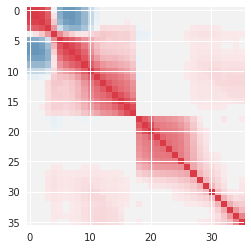

In [39]:
plt.imshow(cov_to_corr(cov ) , cmap=cmap, vmin = -1)

In [40]:
true_data

array([[1.18597304e+03, 8.72112729e+02, 7.31699928e+02, 5.66875110e+02,
        4.48245302e+02, 3.25263708e+02, 2.32006307e+02, 1.70932177e+02,
        1.30233628e+02, 1.02877021e+02, 8.09952540e+01, 6.53262708e+01,
        5.11790378e+01, 3.87034075e+01, 2.83319257e+01, 1.98247417e+01,
        1.28027937e+01, 7.55516821e+00],
       [6.71379329e+01, 5.30962166e+01, 4.09252980e+01, 3.07970210e+01,
        2.26835760e+01, 1.64138793e+01, 1.17071683e+01, 8.21126429e+00,
        5.65477557e+00, 3.80480531e+00, 2.53217008e+00, 1.66578002e+00,
        1.14832764e+00, 8.47343250e-01, 6.36190592e-01, 5.15958796e-01,
        4.19874593e-01, 3.35738606e-01]])

In [41]:
true_param_dict

{'H0': 67.77,
 'Neff': 3.046,
 'alpha': 1.03887697,
 'conc_gal_bias': 1.0,
 'logM0': 11.41003864,
 'logM1': 14.56088772,
 'ns': 0.9667,
 'ombh2': 0.022139921041739997,
 'omch2': 0.11891102387661,
 'sigma8': 0.8228,
 'sigma_logM': 0.44415644,
 'w0': -1.0}

In [42]:
true_data[0]

array([1185.97304254,  872.11272889,  731.6999278 ,  566.87510993,
        448.24530178,  325.2637077 ,  232.0063067 ,  170.9321767 ,
        130.23362818,  102.87702079,   80.99525402,   65.32627076,
         51.17903776,   38.70340748,   28.33192567,   19.8247417 ,
         12.80279372,    7.55516821])

 /u/ki/swmclau2/.local/lib/python2.7/site-packages/pearce/emulator/emu.py:506: UserWarning:Emulator value for logM0 11.410 is outside the bounds (12.600, 13.600) of the emulator.
 /u/ki/swmclau2/.local/lib/python2.7/site-packages/pearce/emulator/emu.py:506: UserWarning:Emulator value for logM0 11.410 is outside the bounds (12.600, 13.600) of the emulator.


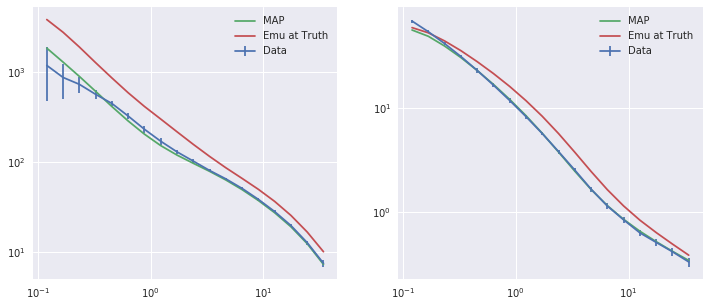

In [43]:
fig = plt.figure(figsize = (12,5))
for i in xrange(len(emus)):
    plt.subplot(1,2,i+1)
    true_pred = emus[i].emulate_wrt_r(true_param_dict).squeeze()
    plt.errorbar(rbc, true_data[i], yerr=yerr[i], label = 'Data')
    plt.plot(rbc, 10**MAP_pred[i], label = 'MAP')
    plt.plot(rbc, (10**true_pred), label = 'Emu at Truth')

    plt.loglog()
    plt.legend(loc='best')
plt.show();

In [44]:
rmin_idxs = rbc > rmin

 /u/ki/swmclau2/.local/lib/python2.7/site-packages/pearce/emulator/emu.py:506: UserWarning:Emulator value for logM0 11.410 is outside the bounds (12.600, 13.600) of the emulator.
 /u/ki/swmclau2/.local/lib/python2.7/site-packages/pearce/emulator/emu.py:506: UserWarning:Emulator value for logM0 11.410 is outside the bounds (12.600, 13.600) of the emulator.


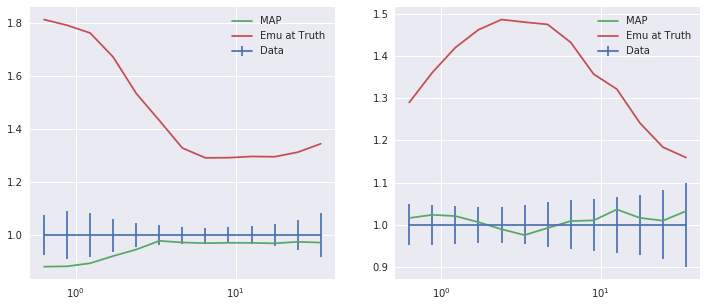

In [45]:
fig = plt.figure(figsize = (12,5))
for i in xrange(len(emus)):
    plt.subplot(1,2,i+1)
    true_pred = emus[i].emulate_wrt_r(true_param_dict).squeeze()
    plt.errorbar(rbc[rmin_idxs], np.ones_like(true_data[i][rmin_idxs]), yerr=yerr[i][rmin_idxs]/true_data[i][rmin_idxs], label = 'Data')
    plt.plot(rbc[rmin_idxs], (10**MAP_pred[i][rmin_idxs])/true_data[i][rmin_idxs], label = 'MAP')
    plt.plot(rbc[rmin_idxs], (10**true_pred[rmin_idxs])/true_data[i][rmin_idxs], label = 'Emu at Truth')
    plt.legend(loc='best')
    plt.xscale('log')
plt.show();

In [46]:
emu.obs

'ds'

In [47]:
rbc

array([ 0.11972916,  0.16697228,  0.23285675,  0.32473812,  0.45287435,
        0.63157098,  0.88077831,  1.22831868,  1.71299265,  2.38891085,
        3.33153506,  4.646103  ,  6.47937742,  9.03603121, 12.60149776,
       17.5738377 , 24.50817968, 34.17869685])

In [48]:
npart_aemulus = 1400**3
npart_mdpl2 = 3840**3

downsample_factor = 1e-2
npart_aemulus_ds = npart_aemulus*downsample_factor
print npart_aemulus_ds, npart_aemulus_ds/npart_mdpl2

27440000.0 0.000484607837818


In [49]:
chain_pnames

array(['ombh2', 'omch2', 'w0', 'ns', 'H0', 'Neff', 'sigma8', 'logM1',
       'logM0', 'sigma_logM', 'alpha', 'conc_gal_bias'], dtype='|S13')

In [50]:
true_pred = np.hstack([emu.emulate_wrt_r(true_param_dict, r_bin_centers=emu.scale_bin_centers).squeeze() for emu in emus])
true_pred = true_pred.reshape((len(emus), -1))

 /u/ki/swmclau2/.local/lib/python2.7/site-packages/pearce/emulator/emu.py:506: UserWarning:Emulator value for logM0 11.410 is outside the bounds (12.600, 13.600) of the emulator.
 /u/ki/swmclau2/.local/lib/python2.7/site-packages/pearce/emulator/emu.py:506: UserWarning:Emulator value for logM0 11.410 is outside the bounds (12.600, 13.600) of the emulator.


In [51]:
cov_rmin_idxs = np.hstack([rmin_idxs for i in xrange(len(emus))])

In [52]:
print 'True Red. Chi2'
R = (10**true_pred[:, rmin_idxs].flatten()-true_data[:, rmin_idxs].flatten())

chi2 =  R.T.dot(inv(cov[cov_rmin_idxs][:,cov_rmin_idxs])).dot(R)
dof = len(chain_pnames)

print chi2/dof

True Red. Chi2
36.73054044147041


In [53]:
print 'Map Red. Chi2'
R = (10**MAP_pred[:, rmin_idxs].flatten()-true_data[:, rmin_idxs].flatten())

chi2 =  R.T.dot(inv(cov[cov_rmin_idxs][:,cov_rmin_idxs])).dot(R)
dof = len(chain_pnames)

print chi2/dof

Map Red. Chi2
0.48294294291514356


In [54]:
N = 6
cmap = sns.color_palette("BrBG_d", N)

In [55]:
emu.get_param_names()

['ombh2',
 'omch2',
 'w0',
 'ns',
 'H0',
 'Neff',
 'sigma8',
 'logM1',
 'logM0',
 'sigma_logM',
 'alpha',
 'conc_gal_bias']

 /u/ki/swmclau2/.local/lib/python2.7/site-packages/pearce/emulator/emu.py:506: UserWarning:Emulator value for logM0 11.410 is outside the bounds (12.600, 13.600) of the emulator.
 /u/ki/swmclau2/.local/lib/python2.7/site-packages/pearce/emulator/emu.py:506: UserWarning:Emulator value for logM0 11.410 is outside the bounds (12.600, 13.600) of the emulator.
 /u/ki/swmclau2/.local/lib/python2.7/site-packages/pearce/emulator/emu.py:506: UserWarning:Emulator value for logM0 11.410 is outside the bounds (12.600, 13.600) of the emulator.
 /u/ki/swmclau2/.local/lib/python2.7/site-packages/pearce/emulator/emu.py:506: UserWarning:Emulator value for logM0 11.410 is outside the bounds (12.600, 13.600) of the emulator.
 /u/ki/swmclau2/.local/lib/python2.7/site-packages/pearce/emulator/emu.py:506: UserWarning:Emulator value for logM0 11.410 is outside the bounds (12.600, 13.600) of the emulator.
 /u/ki/swmclau2/.local/lib/python2.7/site-packages/pearce/emulator/emu.py:506: UserWarning:Emulator value

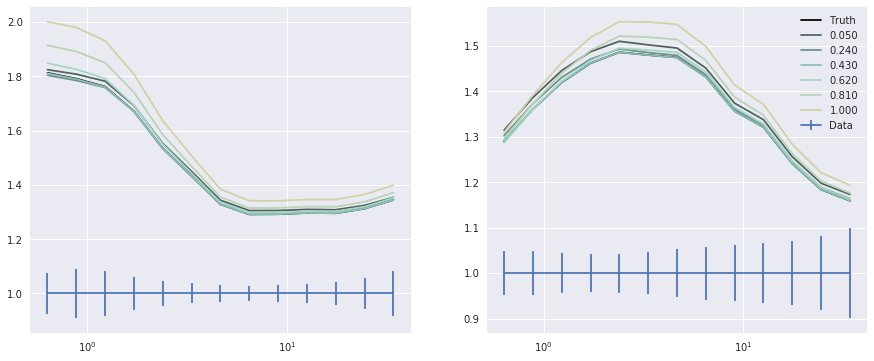

In [60]:
fig = plt.figure(figsize=(15,6))
varied_pname = 'sigma_logM'
lower, upper = 0.05, 1.0#emu.get_param_bounds(varied_pname)

for i in xrange(len(emus)):
    plt.subplot(1,2,i+1)
    plt.errorbar(rbc[rmin_idxs], np.ones_like(true_data[i][rmin_idxs]),\
                 yerr=yerr[i][rmin_idxs]/true_data[i][rmin_idxs], label = 'Data')
    pred = emus[i].emulate_wrt_r(true_param_dict).squeeze()
    #pred = emus[i].emulate_wrt_r(MAP_dict).squeeze()

    plt.plot(rbc[rmin_idxs], (10**pred[rmin_idxs])/true_data[i][rmin_idxs], label = 'Truth', color = 'k')    

    plt.xscale('log')
    
for c, val in zip(cmap, np.linspace(lower, upper, N) ):
    param_dict = true_param_dict.copy()
    #param_dict=  MAP_dict.copy()
    param_dict[varied_pname] = val

    for i in xrange(len(emus)):
        plt.subplot(1,2,i+1)
        pred = emus[i].emulate_wrt_r(param_dict).squeeze()
        plt.plot(rbc[rmin_idxs], (10**pred[rmin_idxs])/true_data[i][rmin_idxs], label = '%.3f'%val, color = c)
    
plt.legend(loc='best')
plt.show();